In [1]:
# Facultatif: pour mettre votre notebook en pleine largeur écran:
from IPython.core.display import HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib inline
from torch import nn, optim
import torch
import time
import sys
from torch import tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data_utils
import torch.nn.functional as F
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# Add library syft for federal learning
import syft as sy
from syft.workers import WebsocketClientWorker

In [2]:
# Create Arguments class with many parameters to be used 
class Arguments():
    def __init__(self):
        self.batch_size = 32
        self.test_batch_size = 32
        self.epochs = 100
        self.lr = 0.01
        self.momentum = 0.5
        self.no_cuda = False
        self.seed = 1
        self.save_model = False

args = Arguments()

use_cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)

device = torch.device("cuda" if use_cuda else "cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [4]:
class NetModel(nn.Module):

    def __init__(self, input_dim, output_dim):

        super(NetModel, self).__init__() 
        # Calling Super Class's constructor
        # nn.linear is defined in nn.Module
        self.linear1 = nn.Linear(input_dim, 30)
        self.linear2 = nn.Linear(30, 30)
        self.linear3 = nn.Linear(30, 30)
        self.linear4 = nn.Linear(30, 1)
        self.sigmoid1 = nn.Sigmoid()
        
        
    def forward(self, x):
        # Here the forward pass is simply a linear function
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = F.relu(self.linear4(x))
        out = self.sigmoid1(x)
        return out

# takes in a module and applies the specified weight initialization
def weights_init_uniform(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

input_dim = 30
output_dim = 1

model = NetModel(input_dim,output_dim)
model.apply(weights_init_uniform)

criterion = nn.BCELoss()# Binary Loss
optimizer = torch.optim.SGD(model.parameters(), lr = args.lr) #Stochastic Gradient Descent

epochs = args.epochs

# Connexion to remote server / websocket

Before this step make sure you start your remote server worker with some data in it. We will create 2 Workers hospital_1 and hospital_2.

In [5]:
# For local  
hook = sy.TorchHook(torch, verbose=True)
torch.manual_seed(args.seed)

In [6]:
kwargs_websocket_1 = {"host": "localhost", "hook": hook, "verbose": True} 
kwargs_websocket_2 = {"host": "localhost", "hook": hook, "verbose": True} 
hospital_1 = WebsocketClientWorker(id="hospital_1", port=8083, **kwargs_websocket_1)
hospital_2 = WebsocketClientWorker(id="hospital_2", port=8084, **kwargs_websocket_2)

In [7]:
features_hospital_1 = hospital_1.search("#train_features")
features_hospital_2 = hospital_2.search("#train_features")

target_hospital_1 = hospital_1.search("train_target")
target_hospital_2 = hospital_2.search("train_target")

data_features = {"hospital_1": features_hospital_1, "hospital_2": features_hospital_2}
data_target = {"hospital_1":target_hospital_1, "hospital_2": target_hospital_2}

In [8]:
# Cast the result in BaseDatasets
datasets = []
for worker in data_features.keys():
    dataset = sy.BaseDataset(data_features[worker][0].float(), data_target[worker][0].float())
    datasets.append(dataset)

# Build the FederatedDataset object
dataset = sy.FederatedDataset(datasets)
federate_train_loader = sy.FederatedDataLoader(dataset, batch_size=32, shuffle=True, drop_last=False, 
                                     **kwargs)

In [9]:
history = { "loss": [], "accuracy": [], "loss_val": [], "accuracy_val": [] }

for epoch in range(epochs):

    epoch +=1
    loss_accum = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(federate_train_loader):

        model.send(data.location)
        optimizer.zero_grad()

        pred = model(data)
        loss =  criterion(pred,target)
        prediction = [1 if x > 0.5 else 0 for x in pred.get().detach().numpy()]
        correct += (prediction == target.get().detach().numpy()).sum()

        loss.backward()
        
        optimizer.step()
        
        model.get()
        loss = loss.get()
        loss_accum += float(loss)
        
       
    history["accuracy"].append(correct / len(federate_train_loader.federated_dataset)*100)
    history["loss"].append(loss_accum / len(federate_train_loader.federated_dataset)*100)        

    print('Epochs', epoch, 'Total accuracy',history["accuracy"][-1], 'Total loss', history['loss'][-1])        

Epochs 1 Total accuracy 56.59050966608085 Total loss 2.1747463826345435
Epochs 2 Total accuracy 54.833040421792624 Total loss 2.162115037546007
Epochs 3 Total accuracy 53.95430579964851 Total loss 2.1504970971226482
Epochs 4 Total accuracy 54.833040421792624 Total loss 2.137312664926995
Epochs 5 Total accuracy 55.88752196836555 Total loss 2.1223457605432334
Epochs 6 Total accuracy 55.88752196836555 Total loss 2.1082130907290013
Epochs 7 Total accuracy 55.18453427065027 Total loss 2.0980138351292936
Epochs 8 Total accuracy 56.239015817223205 Total loss 2.0793903272055574
Epochs 9 Total accuracy 55.88752196836555 Total loss 2.066983541830562
Epochs 10 Total accuracy 56.06326889279437 Total loss 2.053061457635648
Epochs 11 Total accuracy 56.06326889279437 Total loss 2.0391942537103263
Epochs 12 Total accuracy 55.536028119507904 Total loss 2.0282744942314803
Epochs 13 Total accuracy 55.88752196836555 Total loss 2.0075064132837923
Epochs 14 Total accuracy 56.94200351493849 Total loss 1.9800

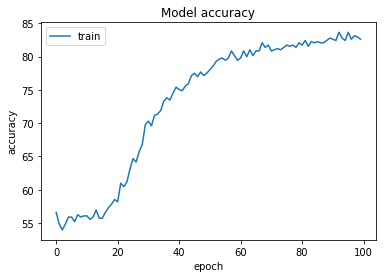

In [10]:
plt.plot(history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

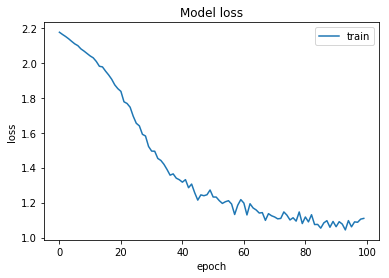

In [11]:
plt.plot(history['loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()